In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)  
import seaborn as sns
import datetime as dt

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

from sklearn import linear_model
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score as acs
from sklearn.metrics import confusion_matrix

__India-Daily Cases__

In [2]:
#Cases APIs
case_time_series=pd.read_csv("https://api.covid19india.org/csv/latest/case_time_series.csv")
case_time_series["Date_YMD"]=pd.to_datetime(case_time_series.Date_YMD,format="%Y-%m-%d")
case_time_series.index=case_time_series['Date_YMD']
#display(case_time_series)
#display(case_time_series.describe())
#display(case_time_series.shape)

#Testing APIs
tested_numbers_icmr_data=pd.read_csv("https://api.covid19india.org/csv/latest/tested_numbers_icmr_data.csv")
#display(tested_numbers_icmr_data.tail())
#tested_numbers_icmr_data.info()

#Create new dataframe for testing data
testingAndVaccinating=pd.DataFrame()
testingAndVaccinating["Date"]=tested_numbers_icmr_data["Tested As Of"]
testingAndVaccinating["Daily Tested"]=tested_numbers_icmr_data["Daily RTPCR Samples Collected_ICMR Application"]
testingAndVaccinating["Total Tested"]=tested_numbers_icmr_data["Total Samples Tested"]
testingAndVaccinating["Total Vaccinations"]=tested_numbers_icmr_data["Total Individuals Vaccinated"]
testingAndVaccinating["Date"]=pd.to_datetime(testingAndVaccinating.Date,infer_datetime_format=True)
testingAndVaccinating.index=testingAndVaccinating["Date"]
testingAndVaccinating.drop(["Date"],axis=1,inplace=True)
testingAndVaccinating.fillna(0,axis=1,inplace=True)
#display(testingAndVaccinating)

In [3]:
#Cases
TC=case_time_series["Total Confirmed"]
TR=case_time_series["Total Recovered"]
TD=case_time_series["Total Deceased"]
X=case_time_series["Daily Confirmed"]
Y=case_time_series["Daily Recovered"]
Z=case_time_series["Daily Deceased"]
D=case_time_series["Date_YMD"]
DF=case_time_series["Date"]
TOTC=case_time_series["Total Confirmed"]
TOTR=case_time_series["Total Recovered"]
TOTD=case_time_series["Total Deceased"]

#Testing and jabs
T=testingAndVaccinating["Daily Tested"]
TV=testingAndVaccinating["Total Vaccinations"]
Tdate=testingAndVaccinating.index
TOTT=testingAndVaccinating["Total Tested"]

DAC=(X-Y-Z)  #Daily Active cases
TAC=(TC-TR-TD) #Total Active cases
AR=(TC-TR-TD)/TC*100  #Active cases ratio
dr=(TD/TC*100) #Death Rate
rr=(TR/TC*100) #Recovery Rate
gr = (X.pct_change(periods=7)*100)/7 #Growth Rate
pr=(X/T)*100 #Positivity rate
pr.dropna()

#Daily change in stats
delC=X.diff()
delR=Y.diff()
delD=Z.diff()
delA=DAC.diff()
delT=T.diff()

#Moving Averages
case_time_series['CMA'] = X.rolling(window=7).mean()
case_time_series['RMA'] = Y.rolling(window=7).mean()
case_time_series['DMA'] = Z.rolling(window=7).mean()
case_time_series['AMA'] = DAC.rolling(window=7).mean()
testingAndVaccinating["TMA"] = T.rolling(window=7).mean()
CMA=case_time_series["CMA"]
RMA=case_time_series["RMA"]
AMA=case_time_series["AMA"]
DMA=case_time_series["DMA"]
TMA=testingAndVaccinating["TMA"]

#Active Cases
Atoday=X[len(X)-1]-Y[len(Y)-1]-Z[len(Z)-1]
TA=TC-TR-TD

__Visualiztion of data__

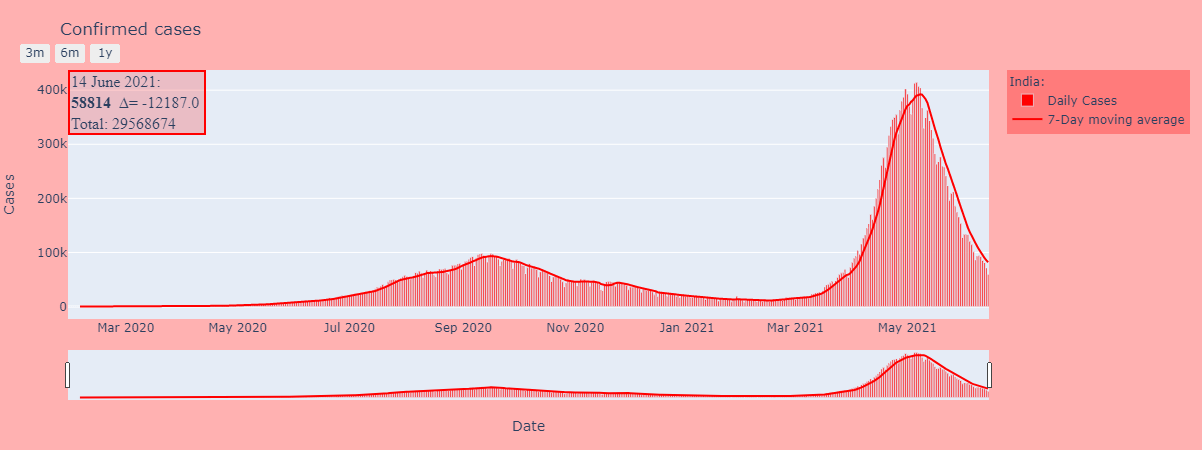

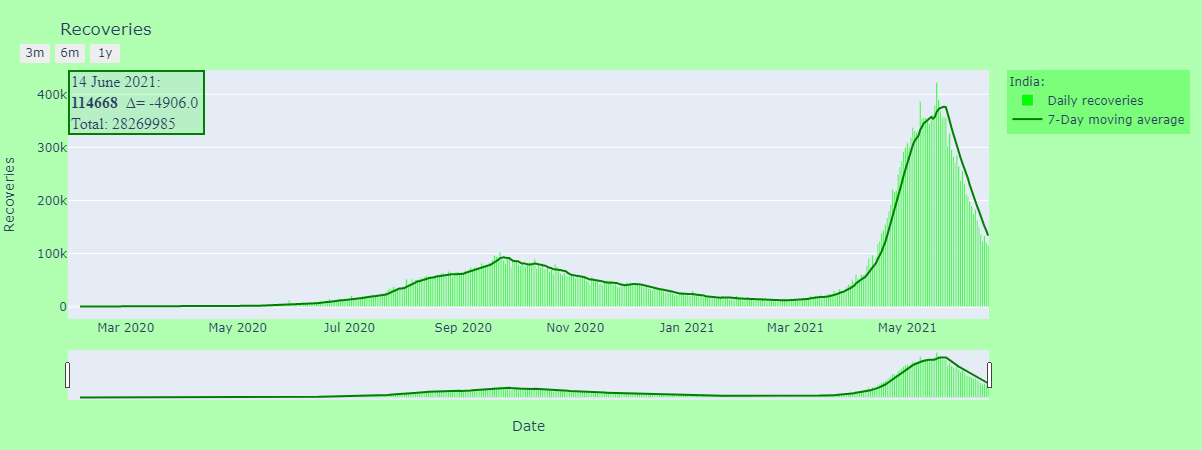

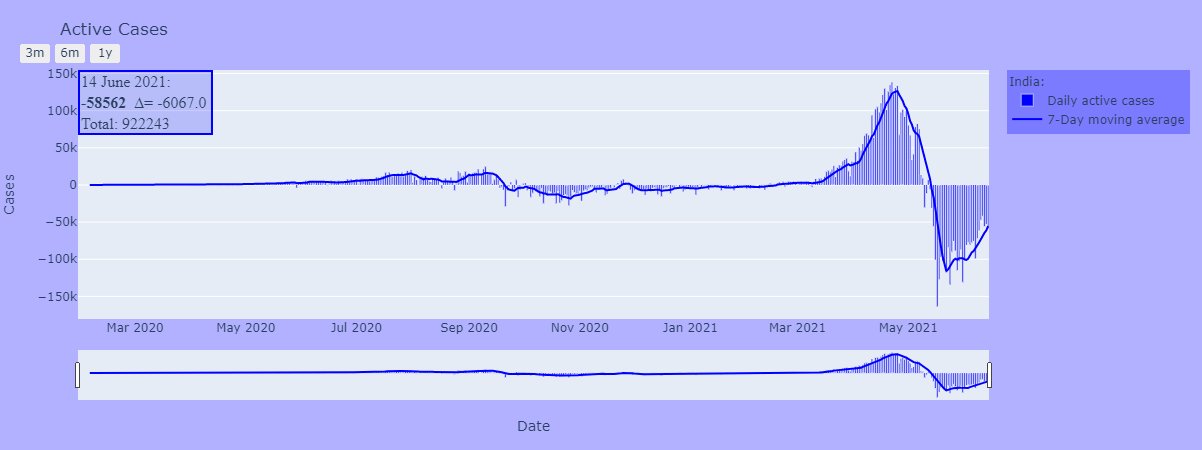

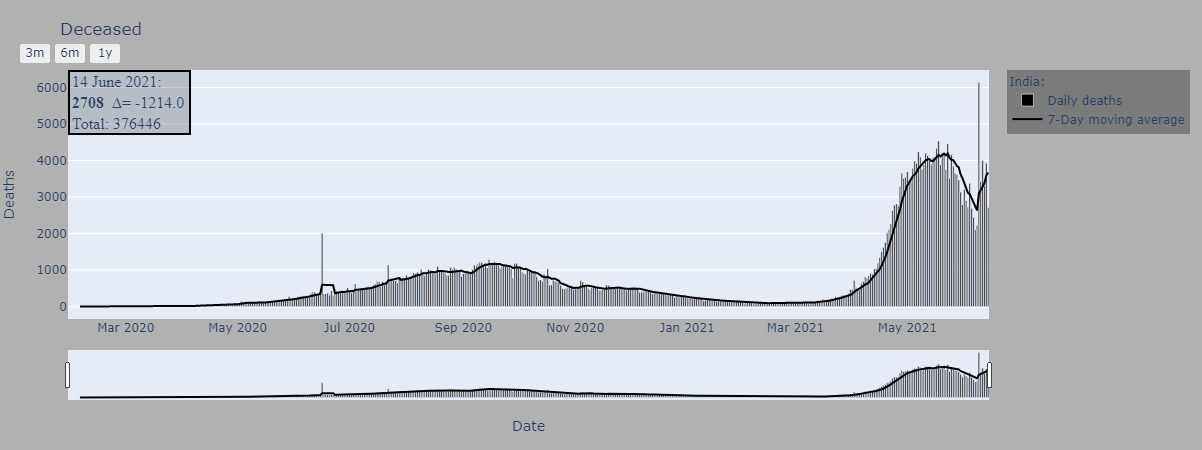

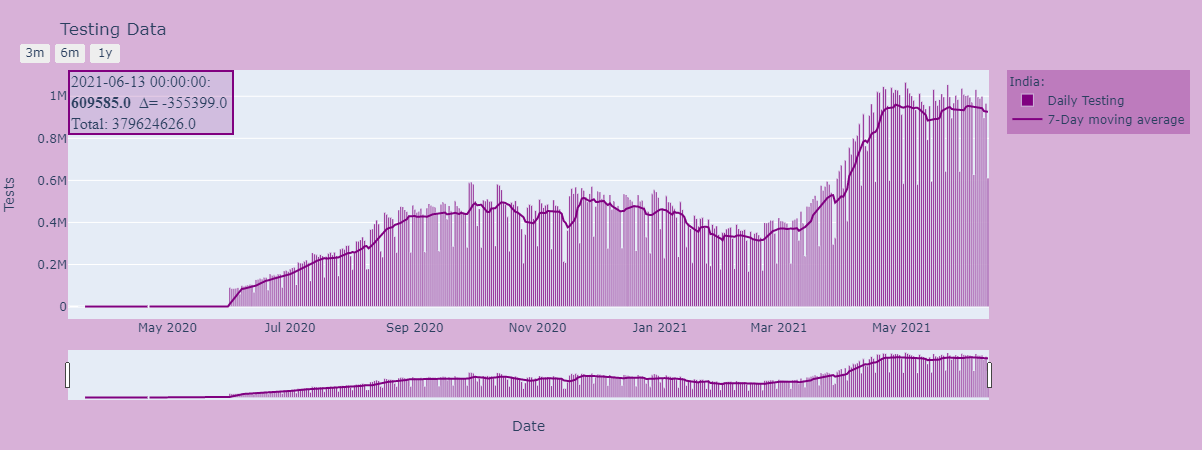

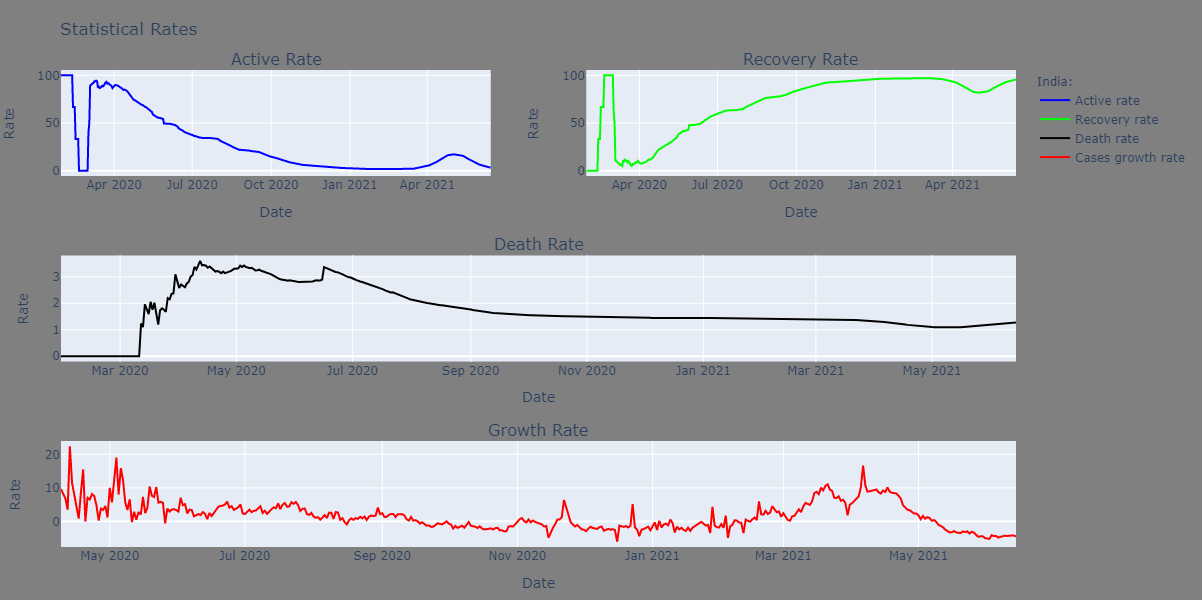

In [4]:
#Confirmed Cases
confirmed = go.Figure(data=[go.Bar(x=D,y=X,    #Trace 1
                                   name="Daily Cases",
                                   marker = dict(color = 'rgba(255, 0, 0,1)'),
                                   text="Peak: {}, Average: {}".format(X.max(),round(X.mean()),2)),
                            go.Scatter(x=D, y=CMA,
                                   mode='lines',
                                   name="7-Day moving average",
                                   line_color="red")]
                     )
confirmed.add_annotation(text="{}:<br><b>{}</b>  ∆= {} <br>Total: {}"
                         .format(DF[len(DF)-1],X[len(X)-1],delC[len(delC)-1],TC[len(TC)-1]),
                         bgcolor='rgba(255, 0, 0,0.2)',
                         font=dict(size=16,family="orbitron"),
                         borderwidth=2,
                         bordercolor="red",
                         x=0, 
                         xanchor="left",
                         xref="paper",
                         y=1,
                         yanchor="top",
                         yref="paper",
                         showarrow=False,
                         align="left" 
                  )
confirmed.update_layout(
    margin=dict(l=20,r=20,b=50,t=70),
    title="Confirmed cases",
    xaxis_title="Date",
    yaxis_title="Cases",
    legend_title="India: ",
    paper_bgcolor='rgba(255, 0, 0,0.3)',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([dict(count=3,step="month",stepmode="backward"),
                          dict(count=6,step="month",stepmode="backward"),
                          dict(count=1,step="year",stepmode="backward")])
        ),
        rangeslider=dict(visible=True),
    )
)

#Recovered Cases
recovered = go.Figure(data=[go.Bar(x=D,y=Y,    #Trace 1
                                   name="Daily recoveries",
                                   marker = dict(color = 'rgba(0, 255, 0,1)'),
                                   text="Peak: {}, Average: {}".format(Y.max(),round(Y.mean()),2)),
                            go.Scatter(x=D, y=RMA,
                                   mode='lines',
                                   name="7-Day moving average",
                                   line_color="green")]
                     )

recovered.add_annotation(text="{}:<br><b>{}</b>  ∆= {} <br>Total: {}"
                         .format(DF[len(DF)-1],Y[len(Y)-1],delR[len(delR)-1],TR[len(TR)-1]),
                         bgcolor='rgba(0, 255, 0,0.2)',
                         font=dict(size=16,family="orbitron"),
                         borderwidth=2,
                         bordercolor="green",
                         x=0, 
                         xanchor="left",
                         xref="paper",
                         y=1,
                         yanchor="top",
                         yref="paper",
                         showarrow=False,
                         align="left"
                        )
recovered.update_layout(
    margin=dict(l=20,r=20,b=50,t=70),
    title="Recoveries",
    xaxis_title="Date",
    yaxis_title="Recoveries",
    legend_title="India: ",
    paper_bgcolor='rgba(0, 255, 0,0.3)',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([dict(count=3,step="month",stepmode="backward"),
                          dict(count=6,step="month",stepmode="backward"),
                          dict(count=1,step="year",stepmode="backward")])
        ),
        rangeslider=dict(visible=True),
    )
)

#Active Cases
active = go.Figure(data=[go.Bar(x=D,y=DAC,    #Trace 1
                                   name="Daily active cases",
                                   marker = dict(color = 'rgba(0, 0, 255,1)'),
                                   text="Peak: {}, Average: {}".format(DAC.max(),round(DAC.mean()),2)),
                            go.Scatter(x=D, y=AMA,
                                   mode='lines',
                                   name="7-Day moving average",
                                   line_color="blue")]
                     )
active.add_annotation(text="{}:<br><b>{}</b>  ∆= {} <br>Total: {}"
                      .format(DF[len(DF)-1],Atoday,delA[len(delA)-1],TA[len(TA)-1]),
                         bgcolor='rgba(0, 0, 255,0.2)',
                         font=dict(size=16,family="orbitron"),
                         borderwidth=2,
                         bordercolor="blue",
                         x=0, 
                         xanchor="left",
                         xref="paper",
                         y=1,
                         yanchor="top",
                         yref="paper",
                         showarrow=False,
                         align="left"
                        )
active.update_layout(
    margin=dict(l=20,r=20,b=50,t=70),
    title="Active Cases",
    xaxis_title="Date",
    yaxis_title="Cases",
    legend_title="India: ",
    paper_bgcolor='rgba(0, 0, 255,0.3)',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([dict(count=3,step="month",stepmode="backward"),
                          dict(count=6,step="month",stepmode="backward"),
                          dict(count=1,step="year",stepmode="backward")])
        ),
        rangeslider=dict(visible=True),
    )
)

#Deaths 
deaths = go.Figure(data=[go.Bar(x=D,y=Z,    #Trace 1
                                   name="Daily deaths",
                                   marker = dict(color = 'rgba(0, 0, 0,1)'),
                                   text="Peak: {}, Average: {}".format(Z.max(),round(Z.mean()),2)),
                            go.Scatter(x=D, y=DMA,
                                   mode='lines',
                                   name="7-Day moving average",
                                   line_color="black")]
                     )
deaths.add_annotation(text="{}:<br><b>{}</b>  ∆= {} <br>Total: {}"
                      .format(DF[len(DF)-1],Z[len(Z)-1],delD[len(delD)-1],TD[len(TD)-1]),
                         bgcolor='rgba(0, 0, 0,0.2)',
                         font=dict(size=16,family="orbitron"),
                         borderwidth=2,
                         bordercolor="black",
                         x=0, 
                         xanchor="left",
                         xref="paper",
                         y=1,
                         yanchor="top",
                         yref="paper",
                         showarrow=False,
                         align="left"
                        )
deaths.update_layout(
    margin=dict(l=20,r=20,b=50,t=70),
    title="Deceased",
    xaxis_title="Date",
    yaxis_title="Deaths",
    legend_title="India: ",
    paper_bgcolor='rgba(0, 0, 0,0.3)',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([dict(count=3,step="month",stepmode="backward"),
                          dict(count=6,step="month",stepmode="backward"),
                          dict(count=1,step="year",stepmode="backward")])
        ),
        rangeslider=dict(visible=True),
    )
)
#Rates
rates = go.Figure(make_subplots(rows=3, cols=2,
                      specs=[[{}, {}],[{"colspan": 2}, None],[{"colspan":2},None]],
                      subplot_titles=("Active Rate", "Recovery Rate","Death Rate","Growth Rate"))
                 )

rates.add_trace(
    go.Scatter(x=D,y=AR,
               mode="lines",
               name="Active rate",
               marker = dict(color = 'rgba(0, 0, 255,1)'),
               text="Maximum: {}%, Average: {}%".format(round(AR.max(),2),round(AR.mean()),2)),
    row=1,col=1
)
rates.add_trace(
    go.Scatter(x=D,y=rr,
               mode="lines",
               name="Recovery rate",
               marker = dict(color = 'rgba(0, 255, 0,1)'),
               text="Maximum: {}%, Average: {}%".format(round(rr.max(),2),round(rr.mean()),2)),
    row=1,col=2
)
rates.add_trace(
    go.Scatter(x=D,y=dr,
               mode="lines",
               name="Death rate",
               marker = dict(color = 'rgba(0, 0, 0,1)'),
               text="Maximum: {}%, Average: {}%".format(round(dr.max(),2),round(dr.mean()),2)),
    row=2,col=1
)
rates.add_trace(
    go.Scatter(x=D[70:],y=gr[70:],
               mode="lines",
               name="Cases growth rate",
               marker = dict(color = 'rgba(255, 0, 0,1)'),
               text="Maximum: {}%, Average: {}%".format(round(gr[70:].max(),2),round(gr[70:].mean()),2)),
    row=3,col=1
)
rates.update_xaxes(title_text="Date", row=1, col=1)
rates.update_xaxes(title_text="Date", row=1, col=2)
rates.update_yaxes(title_text="Rate", row=1, col=1)
rates.update_yaxes(title_text="Rate", row=1, col=2)
rates.update_xaxes(title_text="Date", row=2, col=1)
rates.update_yaxes(title_text="Rate", row=2, col=1)
rates.update_xaxes(title_text="Date", row=3, col=1)
rates.update_yaxes(title_text="Rate", row=3, col=1)

rates.update_layout(
    title_text="Statistical Rates",
    legend_title="India: ",
    paper_bgcolor='grey',
    margin=dict(l=20,r=20,b=50,t=70),
    height=600
)

#Testing
testing = go.Figure(data=[go.Bar(x=Tdate,y=T,    #Trace 1
                                   name="Daily Testing",
                                   marker = dict(color = 'rgba(128, 0, 128,1)'),
                                   text="Peak: {}, Average: {}".format(T.max(),round(T.mean()),2)),
                            go.Scatter(x=testingAndVaccinating.index, y=TMA,
                                   mode='lines',
                                   name="7-Day moving average",
                                   line_color="purple")]
                     )
testing.add_annotation(text="{}:<br><b>{}</b>  ∆= {} <br>Total: {}"
                       .format(Tdate[len(Tdate)-1],T[len(T)-1],delT[len(delT)-1],TOTT[len(TOTT)-1]),
                         bgcolor='rgba(128, 0, 128,0.2)',
                         font=dict(size=16,family="orbitron"),
                         borderwidth=2,
                         bordercolor="purple",
                         x=0, 
                         xanchor="left",
                         xref="paper",
                         y=1,
                         yanchor="top",
                         yref="paper",
                         showarrow=False,
                         align="left" 
                  )
testing.update_layout(
    margin=dict(l=20,r=20,b=50,t=70),
    title="Testing Data",
    xaxis_title="Date",
    yaxis_title="Tests",
    legend_title="India: ",
    paper_bgcolor='rgba(128, 0, 128,0.3)',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([dict(count=3,step="month",stepmode="backward"),
                          dict(count=6,step="month",stepmode="backward"),
                          dict(count=1,step="year",stepmode="backward")])
        ),
        rangeslider=dict(visible=True),
    )
)

confirmed.show()
recovered.show()
active.show()
deaths.show()
testing.show()
rates.show()

# LSTM model to predict curve

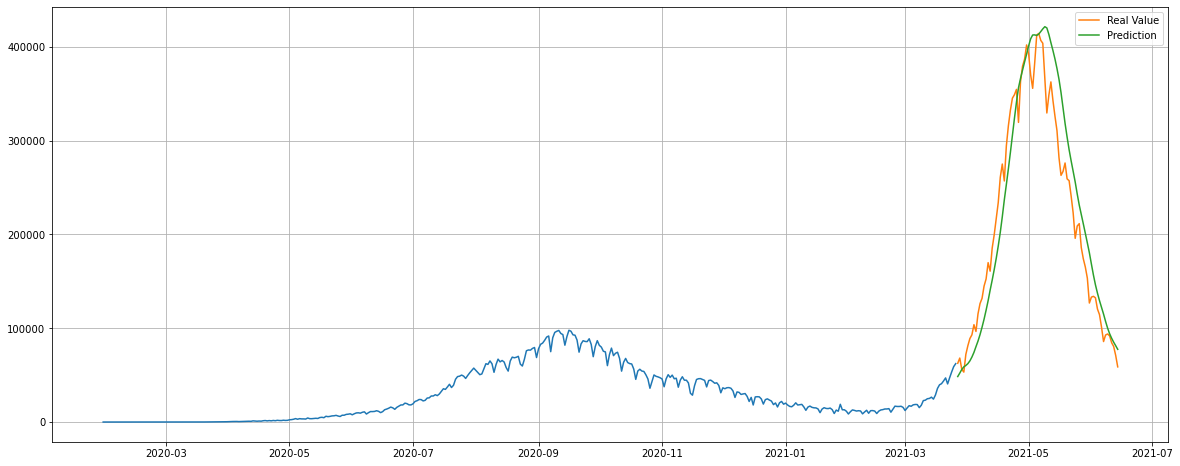

In [6]:
#Testing data for the model
X_test=[]
for i in range(80,inputs_data.shape[0]):
    X_test.append(inputs_data[i-80:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_daily_confirmed=lstm_model.predict(X_test)
predicted_daily_confirmed=scaler.inverse_transform(predicted_daily_confirmed)

train_data=new_dataset[:(len(final_dataset)-80)]
valid_data=new_dataset[(len(final_dataset)-80):]
valid_data['Predictions']=predicted_daily_confirmed

#Confirmed Cases
plt.figure(figsize=(20,8))
plt.plot(train_data["Daily Confirmed"])
plt.plot(valid_data['Daily Confirmed'],label = "Real Value")
plt.plot(valid_data["Predictions"],label = "Prediction")

plt.legend()
plt.grid()
plt.show()

# model = go.Figure(data=[go.Scatter(x=D, y=train_data["Daily Confirmed"],
#                                    mode='lines',
#                                    name="Confirmed Cases",
#                                    line_color="red"),
#                        go.Scatter(x=D, y=valid_data['Daily Confirmed'],
#                                    mode='lines',
#                                    name="Real Value",
#                                    line_color="blue"),
#                        go.Scatter(x=D, y=valid_data['Predictions'],
#                                    mode='lines',
#                                    name="Prediction",
#                                    line_color="yellow")]
#                      )
# model.add_annotation(text="{}:<br><b>{}</b>  ∆= {}".format(DF[len(DF)-1],X[len(X)-1],delC[len(delC)-1]),
#                          bgcolor='rgba(255, 0, 0,0.2)',
#                          font=dict(size=16,family="orbitron"),
#                          borderwidth=2,
#                          bordercolor="red",
#                          x=0, 
#                          xanchor="left",
#                          xref="paper",
#                          y=1,
#                          yanchor="top",
#                          yref="paper",
#                          showarrow=False,
#                          align="left" 
#                   )
# model.update_layout(
#     margin=dict(l=20,r=20,b=50,t=70),
#     title="Prediction Model",
#     xaxis_title="Date",
#     yaxis_title="Cases",
#     legend_title="India: ",
#     paper_bgcolor='rgba(255, 0, 0,0.3)',
#     xaxis=dict(
#         rangeselector=dict(
#             buttons=list([dict(count=3,step="month",stepmode="backward"),
#                           dict(count=6,step="month",stepmode="backward"),
#                           dict(count=1,step="year",stepmode="backward")])
#         ),
#         rangeslider=dict(visible=True),
#     )
# )

__State wise analysis__

In [7]:
#Cases
state_wise_daily = pd.read_csv("https://api.covid19india.org/csv/latest/state_wise_daily.csv")
state_wise_daily["Date_YMD"]=pd.to_datetime(state_wise_daily.Date_YMD,format="%Y-%m-%d")
state_wise=pd.read_csv("https://api.covid19india.org/csv/latest/state_wise.csv")
#display(state_wise)
#display(state_wise.info())
#display(state_wise_daily)
#display(state_wise_daily.info())

#Testing and jabs
statewise_tested_numbers_data=pd.read_csv("https://api.covid19india.org/csv/latest/statewise_tested_numbers_data.csv")
#display(statewise_tested_numbers_data)
statewise_tested_numbers_data["Updated On"]=pd.to_datetime(statewise_tested_numbers_data["Updated On"],
                                                           infer_datetime_format=True, errors = 'coerce')
statewise_tested_numbers_data["State"]=statewise_tested_numbers_data["State"].replace(
    ["Maharashtra","Kerala","Karnataka","Andhra Pradesh","Tamil Nadu","Delhi","Uttar Pradesh","West Bengal","Odisha",
     "Rajasthan","Chhattisgarh","Telangana","Haryana","Gujarat","Bihar","Madhya Pradesh","Assam","Punjab","Jammu and Kashmir",
     "Jharkhand","Uttarakhand","Himachal Pradesh","Goa","Puducherry","Tripura","Manipur","Chandigarh",'Arunachal Pradesh',
     'Meghalaya',"Nagaland","Ladakh","Sikkim","Andaman and Nicobar Islands","Mizoram","Dadra and Nagar Haveli and Daman and Diu",
     "Lakshadweep"],
    ["MH","KL","KA","AP","TN","DL","UP","WB","OR","RJ","CT","TG","HR","GJ","BR","MP","AS","PB","JK","JH","UT","HP","GA","PY",
     "TR","MN","CH","AR","ML","NL","LA","SK","AN","MZ","DN","LD"])
statewise_tested_numbers_data.index=statewise_tested_numbers_data['Updated On']
#statewise_tested_numbers_data

In [8]:
def f(x):
    display(x)
    return x

C = state_wise_daily.columns[3:]
#print("Select a state to view statistics.")
P = interactive(f, x=widgets.Dropdown(options=C,value='MH',description='State Code:',disabled=False))
print("Select a state to view statistics.")
display(P)

Select a state to view statistics.


interactive(children=(Dropdown(description='State Code:', index=22, options=('TT', 'AN', 'AP', 'AR', 'AS', 'BR…

In [9]:
State = P.result
X=state_wise_daily[state_wise_daily.Status=="Confirmed"][State]
Y=state_wise_daily[state_wise_daily.Status=="Recovered"][State]
Z=state_wise_daily[state_wise_daily.Status=="Deceased"][State]
AC=X.values-Y.values-Z.values
Active=pd.DataFrame(AC,columns=["Active"])
DF=state_wise_daily[state_wise_daily.Status=="Confirmed"]["Date"]
D=state_wise_daily[state_wise_daily.Status=="Confirmed"]["Date_YMD"]
TOTC=state_wise[state_wise["State_code"]==State]["Confirmed"]
TOTR=state_wise[state_wise["State_code"]==State]["Recovered"]
TOTD=state_wise[state_wise["State_code"]==State]["Deaths"]
TOTA=TOTC-TOTR-TOTD

#Testing
Date=statewise_tested_numbers_data[statewise_tested_numbers_data.State==State]["Updated On"]
tested=statewise_tested_numbers_data[statewise_tested_numbers_data.State==State]["Total Tested"].diff()
TOTT=statewise_tested_numbers_data[statewise_tested_numbers_data.State==State]["Total Tested"]

#gr = (X.pct_change(periods=7)*100)/7
#pr=(X.values)/(tested.values)*100

#Latest values
Ctoday=X[3*(len(X))-3]
Rtoday=Y[3*(len(Y))-2]
Dtoday=Z[3*(len(Z))-1]
Ttoday=tested[len(tested)-2]
Atoday=Ctoday-Rtoday-Dtoday

#Daily change in stats
delC=X.diff()
delR=Y.diff()
delD=Z.diff()
delA=Active["Active"].diff()
delT=tested.diff()

#Moving Averages
state_wise_daily['CMA'] = X.rolling(window=7).mean()
state_wise_daily['RMA'] = Y.rolling(window=7).mean()
state_wise_daily['DMA'] = Z.rolling(window=7).mean()
Active['AMA'] = Active["Active"].rolling(window=7).mean()
statewise_tested_numbers_data["TMA"]=tested.rolling(window=7).mean()
CMA=state_wise_daily[state_wise_daily.Status=="Confirmed"]["CMA"]
RMA=state_wise_daily[state_wise_daily.Status=="Recovered"]["RMA"]
DMA=state_wise_daily[state_wise_daily.Status=="Deceased"]["DMA"]
AMA=Active["AMA"]
TMA=statewise_tested_numbers_data[statewise_tested_numbers_data.State==State]["TMA"]

# plt.figure(figsize=(16,8))
# plt.bar(D[25:],abs(pr))
# plt.grid()
# plt.show()

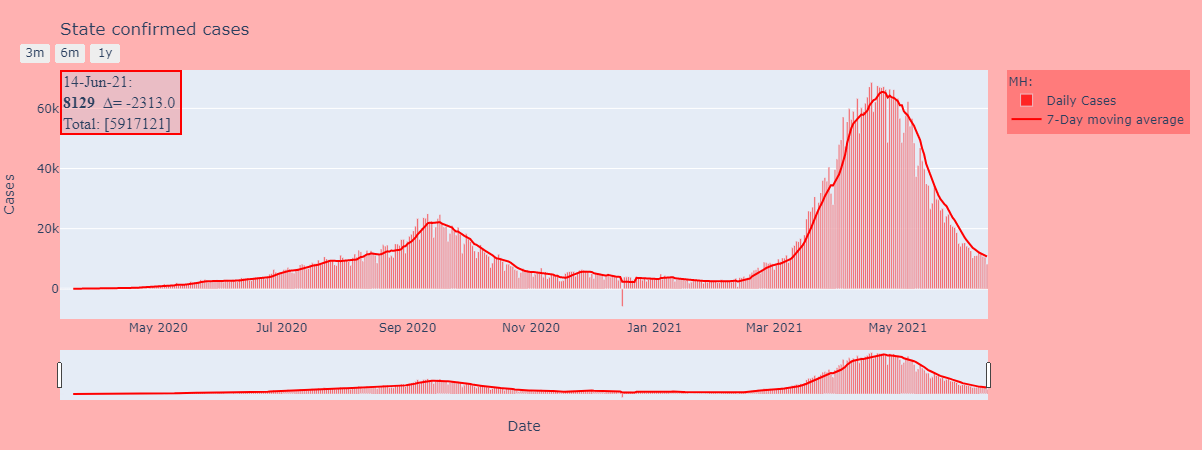

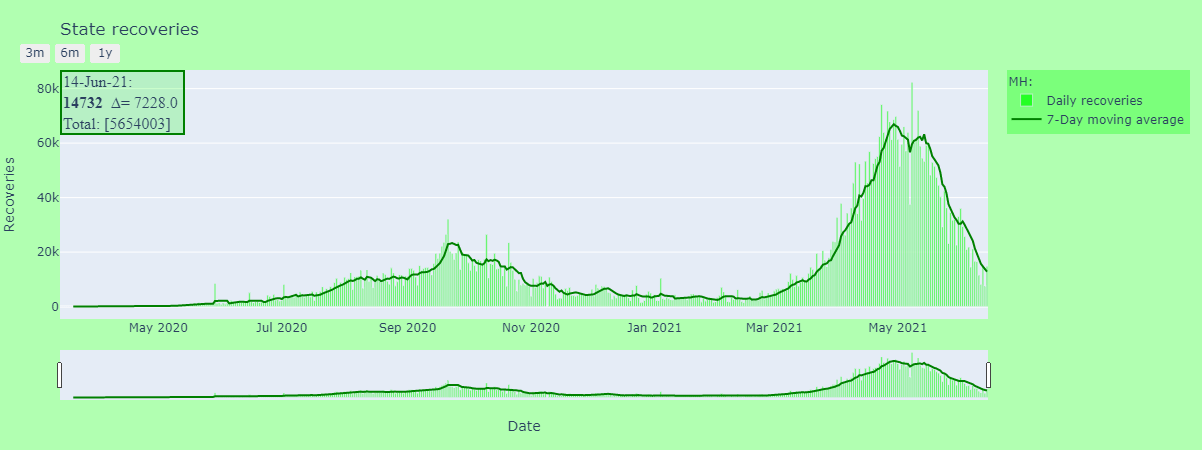

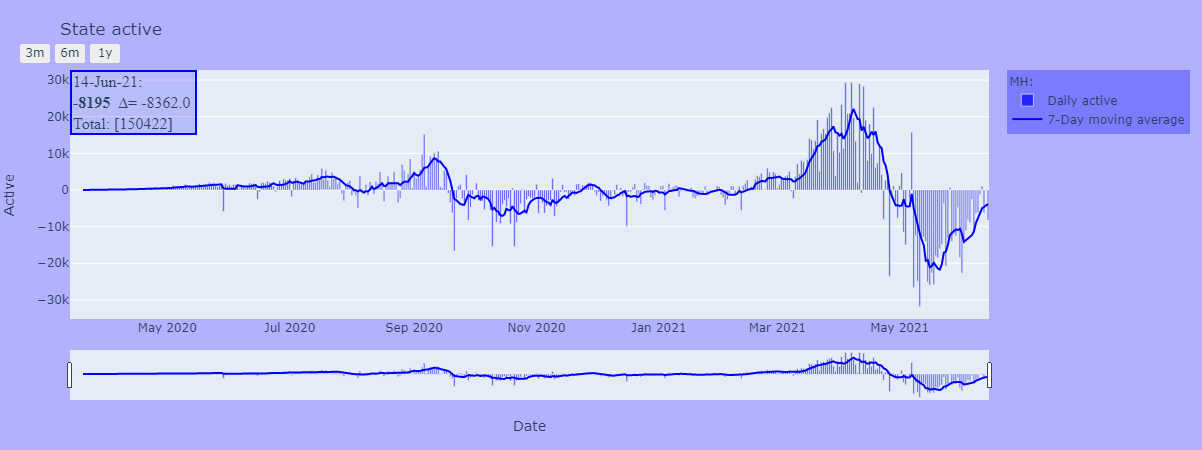

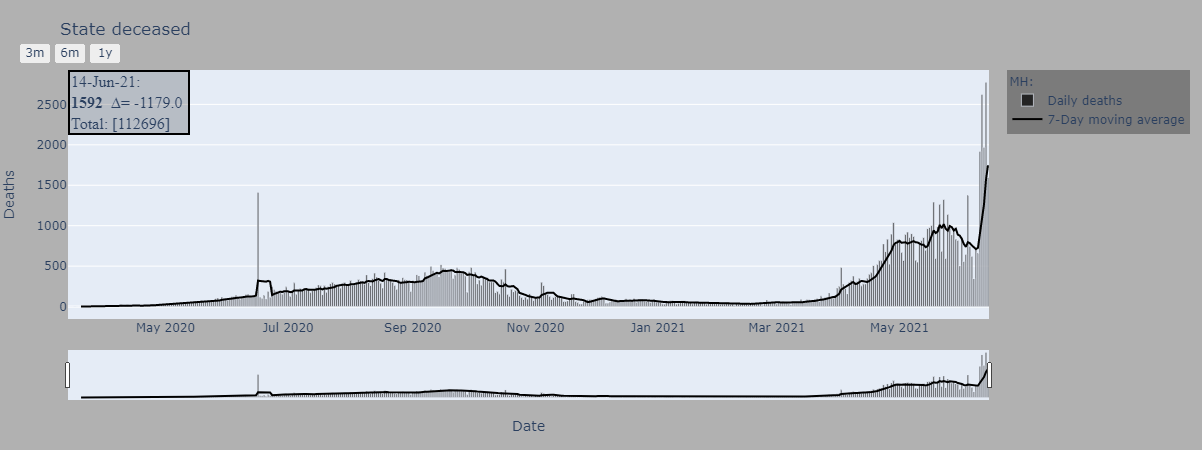

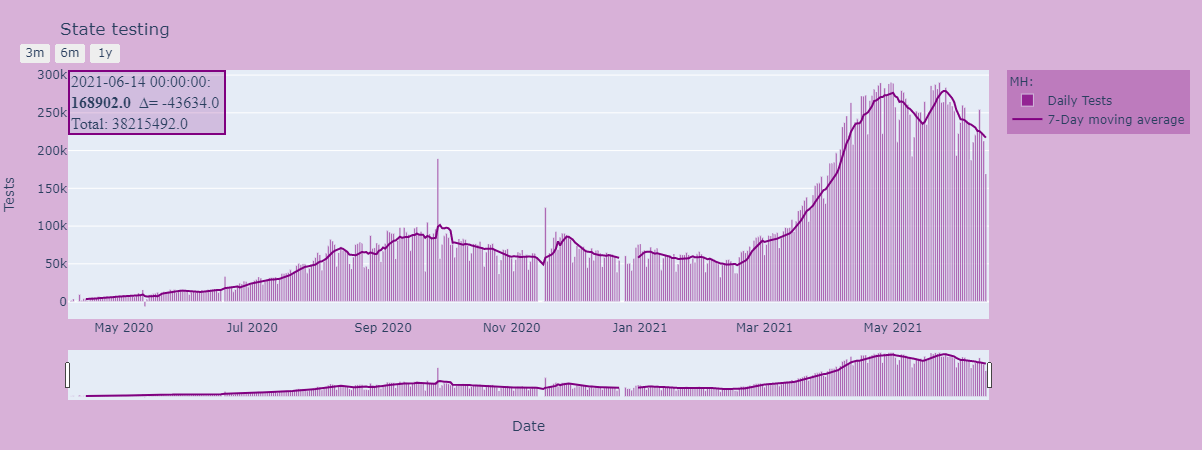

In [10]:
#Confirmed Cases
STconfirmed = go.Figure(data=[go.Bar(x=D,y=X,    #Trace 1
                                   name="Daily Cases",
                                   marker = dict(color = 'rgba(255, 0, 0,0.7)'),
                                   text="Peak: {}, Average: {}".format(X.max(),round(X.mean()),2)),
                            go.Scatter(x=D, y=CMA,
                                   mode='lines',
                                   name="7-Day moving average",
                                   line_color="red")]
                     )
STconfirmed.add_annotation(text="{}:<br><b>{}</b>  ∆= {} <br>Total: {}"
                           .format(DF[3*(len(DF))-3],Ctoday,delC[3*(len(delC))-3],TOTC.values),
                           bgcolor='rgba(255, 0, 0,0.2)',
                           font=dict(size=16,family="orbitron"),
                           borderwidth=2,
                           bordercolor="red",
                           x=0, 
                           xanchor="left",
                           xref="paper",
                           y=1,
                           yanchor="top",
                           yref="paper",
                           showarrow=False,
                           align="left"
                  )
STconfirmed.update_layout(
    margin=dict(l=20,r=20,b=50,t=70),
    title="State confirmed cases",
    xaxis_title="Date",
    yaxis_title="Cases",
    legend_title="{}: ".format(State),
    paper_bgcolor='rgba(255, 0, 0,0.3)',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([dict(count=3,step="month",stepmode="backward"),
                          dict(count=6,step="month",stepmode="backward"),
                          dict(count=1,step="year",stepmode="backward")])
        ),
        rangeslider=dict(visible=True),
    )
)

#Recovered Cases
STrecovered = go.Figure(data=[go.Bar(x=D,y=Y,    #Trace 1
                                   name="Daily recoveries",
                                   marker = dict(color = 'rgba(0, 255, 0,0.7)'),
                                   text="Peak: {}, Average: {}".format(Y.max(),round(Y.mean()),2)),
                            go.Scatter(x=D, y=RMA,
                                   mode='lines',
                                   name="7-Day moving average",
                                   line_color="green")]
                     )
STrecovered.add_annotation(text="{}:<br><b>{}</b>  ∆= {} <br>Total: {}"
                           .format(DF[3*(len(DF))-3],Rtoday,delR[3*(len(delR))-2],TOTR.values),
                           bgcolor='rgba(0, 255, 0,0.2)',
                           font=dict(size=16,family="orbitron"),
                           borderwidth=2,
                           bordercolor="green",
                           x=0, 
                           xanchor="left",
                           xref="paper",
                           y=1,
                           yanchor="top",
                           yref="paper",
                           showarrow=False,
                           align="left"
                  )
STrecovered.update_layout(
    margin=dict(l=20,r=20,b=50,t=70),
    title="State recoveries",
    xaxis_title="Date",
    yaxis_title="Recoveries",
    legend_title="{}: ".format(State),
    paper_bgcolor='rgba(0, 255, 0,0.3)',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([dict(count=3,step="month",stepmode="backward"),
                          dict(count=6,step="month",stepmode="backward"),
                          dict(count=1,step="year",stepmode="backward")])
        ),
        rangeslider=dict(visible=True),
    )
)

#Active Cases
STactive = go.Figure(data=[go.Bar(x=D,y=Active["Active"],    #Trace 1
                                   name="Daily active",
                                   marker = dict(color = 'rgba(0, 0, 255,0.7)'),
                                   text="Peak: {}, Average: {}".format(Active["Active"].max(),round(Active["Active"].mean()),2)),
                            go.Scatter(x=D, y=AMA,
                                   mode='lines',
                                   name="7-Day moving average",
                                   line_color="blue")
                          ]
                     )
STactive.add_annotation(text="{}:<br><b>{}</b>  ∆= {} <br>Total: {}"
                        .format(DF[3*(len(DF))-3],Atoday,delA[len(delA)-1],TOTA.values),
                           bgcolor='rgba(0, 0, 255,0.2)',
                           font=dict(size=16,family="orbitron"),
                           borderwidth=2,
                           bordercolor="blue",
                           x=0, 
                           xanchor="left",
                           xref="paper",
                           y=1,
                           yanchor="top",
                           yref="paper",
                           showarrow=False,
                           align="left"
                  )
STactive.update_layout(
    margin=dict(l=20,r=20,b=50,t=70),
    title="State active",
    xaxis_title="Date",
    yaxis_title="Active",
    legend_title="{}: ".format(State),
    paper_bgcolor='rgba(0, 0, 255,0.3)',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([dict(count=3,step="month",stepmode="backward"),
                          dict(count=6,step="month",stepmode="backward"),
                          dict(count=1,step="year",stepmode="backward")])
        ),
        rangeslider=dict(visible=True),
    )
)

#Deaths 
STdeaths = go.Figure(data=[go.Bar(x=D,y=Z,    #Trace 1
                                   name="Daily deaths",
                                   marker = dict(color = 'rgba(0, 0, 0,0.7)'),
                                   text="Peak: {}, Average: {}".format(Z.max(),round(Z.mean()),2)),
                            go.Scatter(x=D, y=DMA,
                                   mode='lines',
                                   name="7-Day moving average",
                                   line_color="black")]
                     )
STdeaths.add_annotation(text="{}:<br><b>{}</b>  ∆= {} <br>Total: {}"
                        .format(DF[3*(len(DF))-3],Dtoday,delD[3*(len(delD))-1],TOTD.values),
                           bgcolor='rgba(0, 0, 0,0.2)',
                           font=dict(size=16,family="orbitron"),
                           borderwidth=2,
                           bordercolor="black",
                           x=0, 
                           xanchor="left",
                           xref="paper",
                           y=1,
                           yanchor="top",
                           yref="paper",
                           showarrow=False,
                           align="left"
                  )
STdeaths.update_layout(
    margin=dict(l=20,r=20,b=50,t=70),
    title="State deceased",
    xaxis_title="Date",
    yaxis_title="Deaths",
    legend_title="{}: ".format(State),
    paper_bgcolor='rgba(0, 0, 0,0.3)',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([dict(count=3,step="month",stepmode="backward"),
                          dict(count=6,step="month",stepmode="backward"),
                          dict(count=1,step="year",stepmode="backward")])
        ),
        rangeslider=dict(visible=True),
    )
)

#Testing
STTesting=go.Figure(data=[go.Bar(x=Date,y=tested,    #Trace 1
                                   name="Daily Tests",
                                   marker = dict(color = 'rgba(128, 0, 128,0.7)'),
                                   text="Peak: {}, Average: {}".format(tested.max(),round(tested.mean()),2)),
                            go.Scatter(x=Date, y=TMA,
                                   mode='lines',
                                   name="7-Day moving average",
                                   line_color="purple")]
                     )
STTesting.add_annotation(text="{}:<br><b>{}</b>  ∆= {} <br>Total: {}"
                         .format(Date[len(Date)-2],Ttoday,delT[len(delT)-2],TOTT[len(TOTT)-2]),
                           bgcolor='rgba(128, 0, 128,0.2)',
                           font=dict(size=16,family="orbitron"),
                           borderwidth=2,
                           bordercolor="purple",
                           x=0, 
                           xanchor="left",
                           xref="paper",
                           y=1,
                           yanchor="top",
                           yref="paper",
                           showarrow=False,
                           align="left"
                  )
STTesting.update_layout(
    margin=dict(l=20,r=20,b=50,t=70),
    title="State testing",
    xaxis_title="Date",
    yaxis_title="Tests",
    legend_title="{}: ".format(State),
    paper_bgcolor='rgba(128, 0, 128,0.3)',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([dict(count=3,step="month",stepmode="backward"),
                          dict(count=6,step="month",stepmode="backward"),
                          dict(count=1,step="year",stepmode="backward")])
        ),
        rangeslider=dict(visible=True),
    )
)

STconfirmed.show()
STrecovered.show()
STactive.show()
STdeaths.show()
STTesting.show()

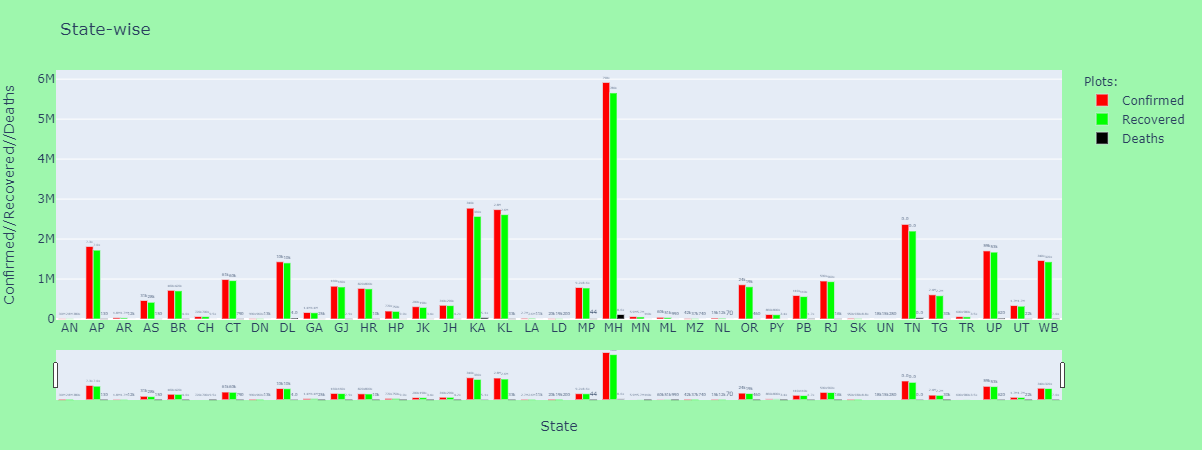

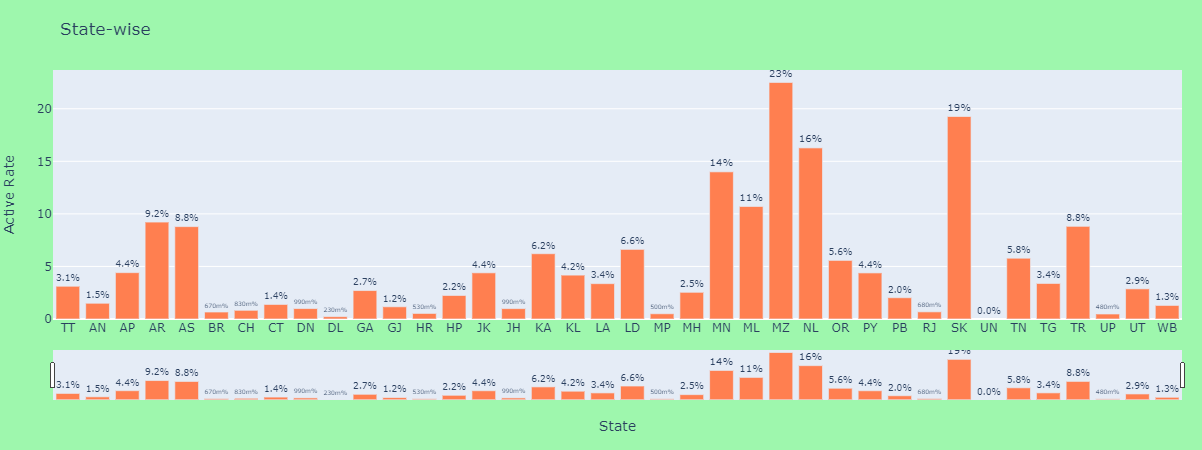

In [11]:
SWC=state_wise["Confirmed"]
SWR=state_wise["Recovered"]
SWD=state_wise["Deaths"]
T=state_wise[state_wise.State=="Total"]
SC=state_wise["State_code"]
ar=((SWC-SWR-SWD)/SWC*100)

#Display
PR = go.Figure(data=[go.Bar(x=SC[state_wise.State!="Total"],y=SWC[state_wise.State!="Total"],    #Trace 1
                                   name="Confirmed",
                            text=SWC,
                                   marker = dict(color = 'rgba(255, 0, 0,1)'),
                           ),
                     go.Bar(x=SC[state_wise.State!="Total"],y=SWR[state_wise.State!="Total"],name="Recovered",
                            text=SWR,
                            marker=dict(color = 'rgba(0, 255, 0,1)')),
                     go.Bar(x=SC[state_wise.State!="Total"],y=SWD[state_wise.State!="Total"],name="Deaths",
                            text=SWD,
                            marker=dict(color = 'rgba(0, 0, 0,1)')),
                    ]
                    
              )
PR.update_traces(texttemplate='%{text:.2s}', textposition='outside')
PR.update_layout(
    margin=dict(l=20,r=20,b=50,t=70),
    title="State-wise",
    xaxis_title="State",
    yaxis_title="Confirmed//Recovered//Deaths",
    legend_title="Plots: ",
    paper_bgcolor='#9ef7ad',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([dict(count=3,step="month",stepmode="backward"),
                          dict(count=6,step="month",stepmode="backward"),
                          dict(count=1,step="year",stepmode="backward")])
        ),
        rangeslider=dict(visible=True),
    )
)
AR = go.Figure(data=[go.Bar(x=SC,y=ar,    #Trace 1
                                   name="Active Rate",
                            text=ar,
                                   marker = dict(color = '#FF7F50'),
                           )]    
              )
AR.update_traces(texttemplate='%{text:.2s}%', textposition='outside')
AR.update_layout(
    margin=dict(l=20,r=20,b=50,t=70),
    title="State-wise",
    xaxis_title="State",
    yaxis_title="Active Rate",
    legend_title="Plots: ",
    paper_bgcolor='#9ef7ad',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([dict(count=3,step="month",stepmode="backward"),
                          dict(count=6,step="month",stepmode="backward"),
                          dict(count=1,step="year",stepmode="backward")])
        ),
        rangeslider=dict(visible=True),
    )
)
PR.show()
AR.show()

In [12]:
#world_data=pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")
#world_data.info()